In [4]:
#Training the model on 30k datasets.

import random
import numpy as np
from Bio import SeqIO
import gzip
import os
import pickle
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Activation, Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Dropout
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import pandas as pd
import matplotlib.pyplot as plt

#Set random seeds for reproducibility.
np.random.seed(4)
random.seed(5)
set_random_seed(4) 



def load_data(path):   
    data = gzip.open(os.path.join(path,"sequences.fa.gz"),"rt")
    return data


def get_seq(protein, t_data, training_set_number): 
    if t_data == "train":     
        training_data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((30000,101,4))          
    
    elif t_data == "test":          
        training_data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
        x_train = np.zeros((10000,101,4))      
    r = 0 
    for record in SeqIO.parse(training_data,"fasta"):
        sequence = list(record.seq)                
        nucleotide = {'A' : 0, 'T' : 1, 'G' : 2, 'C' : 3, 'N' : 4} 
        num_seq = list() #Encoded sequence
        for i in range(0,len(sequence)):
                num_seq.append(nucleotide[sequence[i]])

        X = np.zeros((1,len(num_seq),4))
        for i in range (len(num_seq)):
                if num_seq[i] <= 3:
                    X[:,i,num_seq[i]] = 1               
        x_train[r,:,:] = X
        r = r + 1
    
    return x_train


def get_class(protein, t_data,training_set_number):
    y_train = []
    if t_data == 'train':
        data = load_data("datasets/clip/%s/30000/training_sample_%s"% (protein, training_set_number))
    elif t_data == 'test':
        data = load_data("datasets/clip/%s/30000/test_sample_%s"% (protein, training_set_number))
    for record in SeqIO.parse(data,"fasta"):
        v = int((record.description).split(":")[1])
        # [1,0] if there was no observed binding and [0,1] for sequences where binding was observed.
        y_train.append([int(v == 0), int(v != 0)])

    y_train = np.array(y_train)
    return y_train


def get_cobinding(protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1)       
        cobinding = np.zeros((30000,101,int(cobinding_data.shape[1]/101)),dtype=np.int)    
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_Cobinding.tab.gz"% (protein, training_set_number)), "rt") as f:
            cobinding_data = np.loadtxt(f, skiprows=1) 
        cobinding = np.zeros((10000,101,int(cobinding_data.shape[1]/101)),dtype=np.int)
    for n in range(0,cobinding_data.shape[1],101):
        a = cobinding_data[:,n:(n+101)]
        cobinding[:,:,int(n/101)] = a
    
    return cobinding
    

def get_region (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1)
        region = np.zeros((30000,101,int(region_data.shape[1]/101)),dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RegionType.tab.gz"% (protein, training_set_number)), "rt") as f:
            region_data = np.loadtxt(f, skiprows=1) 
        region = np.zeros((10000,101,int(region_data.shape[1]/101)),dtype=np.int)
    for n in range(0,region_data.shape[1],101):
        a = region_data[:,n:(n+101)]
        region[:,:,int(n/101)] = a
        
    return region


def get_fold (protein, t_data, training_set_number):
    if t_data == "train":
        with gzip.open(("datasets/clip/%s/30000/training_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((30000,101,int(fold_data.shape[1]/101)), dtype=np.int)
                             
    elif t_data == "test":
        with gzip.open(("datasets/clip/%s/30000/test_sample_%s/matrix_RNAfold.tab.gz"% (protein, training_set_number)), "rt") as f:
            fold_data = np.loadtxt(f, skiprows=1) 
        fold = np.zeros((10000,101,int(fold_data.shape[1]/101)),dtype=np.int)




    for n in range(0,fold_data.shape[1],101):
        a = fold_data[:,n:(n+101)]
        fold[:,:,int(n/101)] = a
    
    
    return fold

def load_data_sources(protein, t_data, training_set_number, *args):
    X = np.array([])
    data_sources = []
    for arg in args:
        
        if arg == 'KMER':
            if X.size == 0:
                X = get_seq(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_seq(protein, t_data, training_set_number)))
        if arg == 'RNA': 
            if X.size == 0:
                X = get_fold(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_fold(protein, t_data, training_set_number)))
        if arg == 'RG':   
            if X.size == 0:
                X = get_region(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_region(protein, t_data, training_set_number)))
        if arg == 'CLIP': 
            if X.size == 0:
                X = get_cobinding(protein, t_data, training_set_number)
            else: 
                X = np.dstack((X, get_cobinding(protein, t_data, training_set_number)))
        data_sources.append(arg)
        
    data_sources = ','.join(data_sources)
    return data_sources, X


In [2]:
#TRAIN
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
average_score = np.zeros(len(protein_list))
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']


for training_set_number in range (3):
        
    score_list = []
    
    if not os.path.exists("results/set_%s" % training_set_number):
        os.makedirs("results/set_%s" % training_set_number)
    
    for protein in protein_list:
        
        if not os.path.exists("results/set_%s/%s" % (training_set_number,protein)):
            os.makedirs("results/set_%s/%s" % (training_set_number,protein))
    
        print (protein)

        data_sources, X = load_data_sources(protein, 'train', training_set_number, *experiment_set)
        y = get_class(protein,"train",training_set_number)
        size = X.shape[2]
        score = []
        
        model = Sequential()
        model.add(Conv1D(10,6, data_format='channels_last', input_shape=(101, size) , strides = 1, padding='valid'))
        model.add(MaxPooling1D(pool_size=20, strides=1, padding='valid'))
        model.add(Conv1D(10, 4, activation='relu'))
        model.add(Dropout(0.1))
        model.add(MaxPooling1D(pool_size=40, strides=1, padding='valid'))
        model.add(Conv1D(15, 4, activation='relu'))
        model.add(MaxPooling1D(pool_size=30, strides=1, padding='valid'))
        model.add(Conv1D(15, 3, activation='relu'))
        model.add(GlobalAveragePooling1D())
        model.add(Dense(200, activation='relu'))
        model.add(Dropout(0.1))
        model.add(Dense(2, activation='softmax'))

        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        checkpointer = ModelCheckpoint(filepath="models/" + protein + "_weights.hdf5", verbose=0, save_best_only=True)
        earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=0)
        metrics = model.fit(X, y, validation_split = 0.2, epochs=12, batch_size=200, verbose=0, callbacks=[earlystopper])

      
        #Save score list
        with open ("results/set_%s/%s/score" % (training_set_number, protein), "w") as score_file:
            np.save(("results/set_%s/%s/score" % (training_set_number, protein)), score)
        
        #Save model and weights to .json file.
        json_model = model.to_json()
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "w") as json_file:
            json_file.write(json_model)
        with open ("results/set_%s/%s/weights.h5" % (training_set_number, protein), "w") as weights_file:
            model.save_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))
        
        #Save the model metrics generated with model fit.
        with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "w") as pickle_file:
            pickle.dump(metrics, pickle_file, protocol=pickle.HIGHEST_PROTOCOL)



1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19

In [31]:
#TEST
from keras.models import model_from_json


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
experiment_set = ['KMER' , 'RNA', 'RG', 'CLIP']
# Run predictions on all of the 3 test datasets.
for training_set_number in range (3):
    for protein in protein_list:
       
        #Load the model and weights.
        with open("results/set_%s/%s/model.json" % (training_set_number, protein), "r") as json_file:
            json = json_file.read()
            loaded_model = model_from_json(json)
            loaded_model.load_weights("results/set_%s/%s/weights.h5" % (training_set_number, protein))


        #Load data for testing purposes.
        data_sources, X_test = load_data_sources(protein, 'test', training_set_number, *experiment_set)


        #Run predictions on test dataset and save them.
        predictions = loaded_model.predict(X_test)
                                              
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "wb") as predictions_file:
            np.save(predictions_file, predictions)



1_PARCLIP_AGO1234_hg19


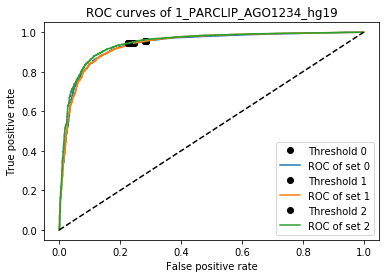

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 1_PARCLIP_AGO1234_hg19, with the average AUC of 0.9392143229166666 across all three datasets.
2_PARCLIP_AGO2MNASE_hg19


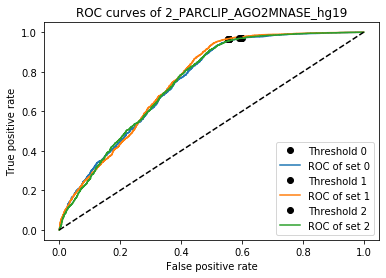

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 2_PARCLIP_AGO2MNASE_hg19, with the average AUC of 0.7524039895833333 across all three datasets.
3_HITSCLIP_Ago2_binding_clusters


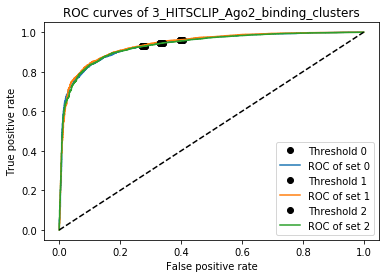

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 3_HITSCLIP_Ago2_binding_clusters, with the average AUC of 0.9369149270833333 across all three datasets.
4_HITSCLIP_Ago2_binding_clusters_2


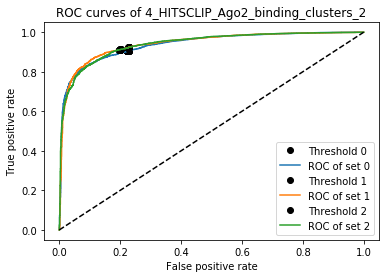

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 4_HITSCLIP_Ago2_binding_clusters_2, with the average AUC of 0.9400964583333332 across all three datasets.
5_CLIPSEQ_AGO2_hg19


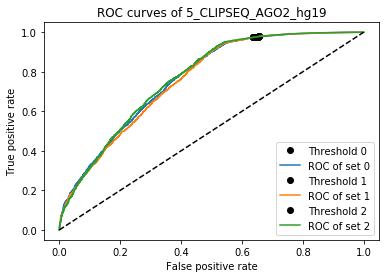

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 5_CLIPSEQ_AGO2_hg19, with the average AUC of 0.76447290625 across all three datasets.
6_CLIP-seq-eIF4AIII_1


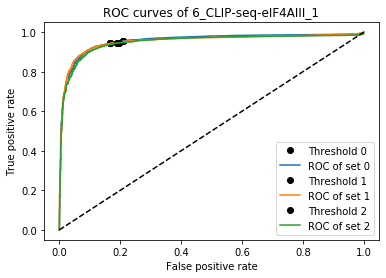

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 6_CLIP-seq-eIF4AIII_1, with the average AUC of 0.9531564895833333 across all three datasets.
7_CLIP-seq-eIF4AIII_2


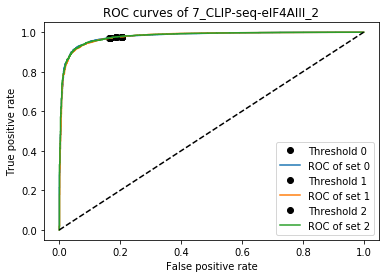

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 7_CLIP-seq-eIF4AIII_2, with the average AUC of 0.9787366458333334 across all three datasets.
8_PARCLIP_ELAVL1_hg19


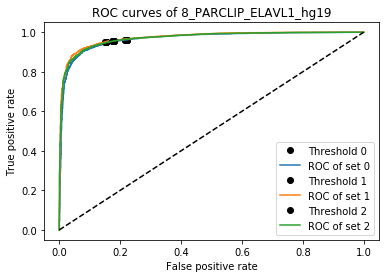

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 8_PARCLIP_ELAVL1_hg19, with the average AUC of 0.9694093333333332 across all three datasets.
9_PARCLIP_ELAVL1MNASE_hg19


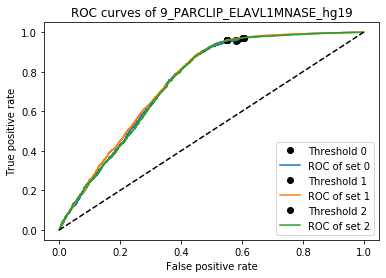

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 9_PARCLIP_ELAVL1MNASE_hg19, with the average AUC of 0.7520650416666665 across all three datasets.
10_PARCLIP_ELAVL1A_hg19


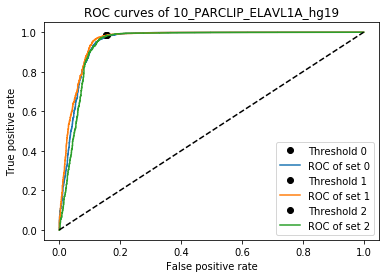

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 10_PARCLIP_ELAVL1A_hg19, with the average AUC of 0.9510720729166667 across all three datasets.
10_PARCLIP_ELAVL1A_hg19


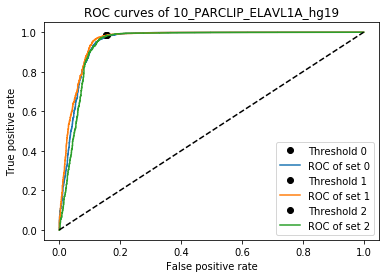

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 10_PARCLIP_ELAVL1A_hg19, with the average AUC of 0.9510720729166667 across all three datasets.
12_PARCLIP_EWSR1_hg19


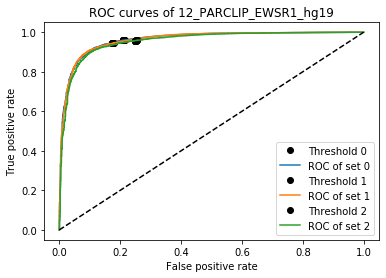

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 12_PARCLIP_EWSR1_hg19, with the average AUC of 0.9596307708333334 across all three datasets.
13_PARCLIP_FUS_hg19


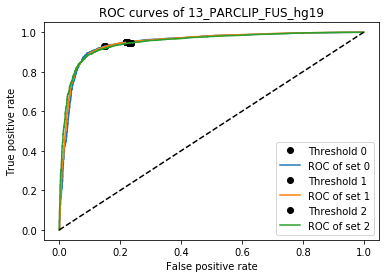

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 13_PARCLIP_FUS_hg19, with the average AUC of 0.9471521770833333 across all three datasets.
14_PARCLIP_FUS_mut_hg19


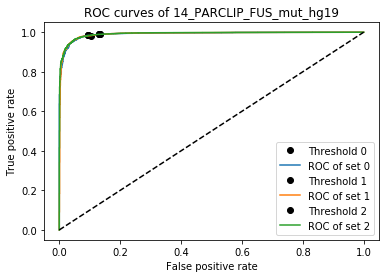

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 14_PARCLIP_FUS_mut_hg19, with the average AUC of 0.9911667291666667 across all three datasets.
15_PARCLIP_IGF2BP123_hg19


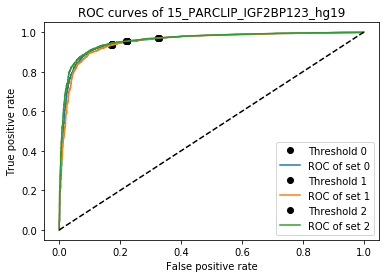

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 15_PARCLIP_IGF2BP123_hg19, with the average AUC of 0.9552266145833334 across all three datasets.
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


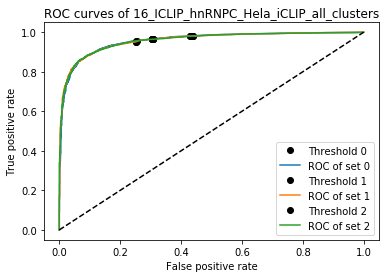

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters, with the average AUC of 0.9577844479166666 across all three datasets.
17_ICLIP_HNRNPC_hg19


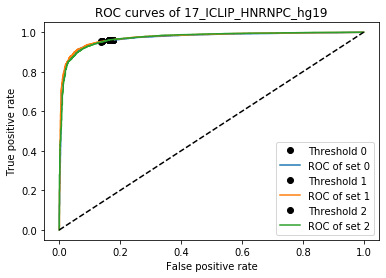

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 17_ICLIP_HNRNPC_hg19, with the average AUC of 0.9722244062500001 across all three datasets.
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


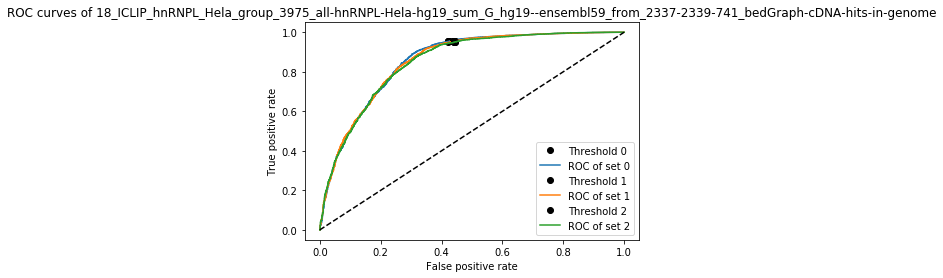

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.8538024375000001 across all three datasets.
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


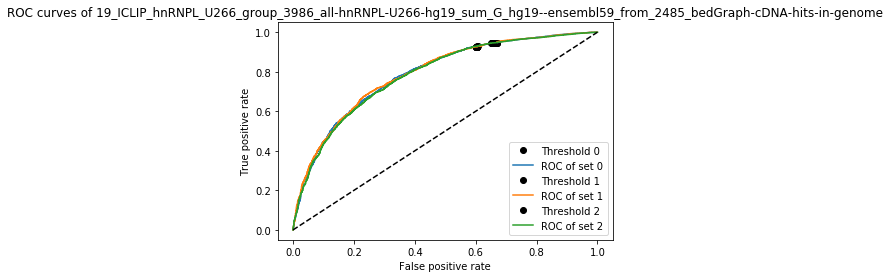

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7888937604166667 across all three datasets.
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


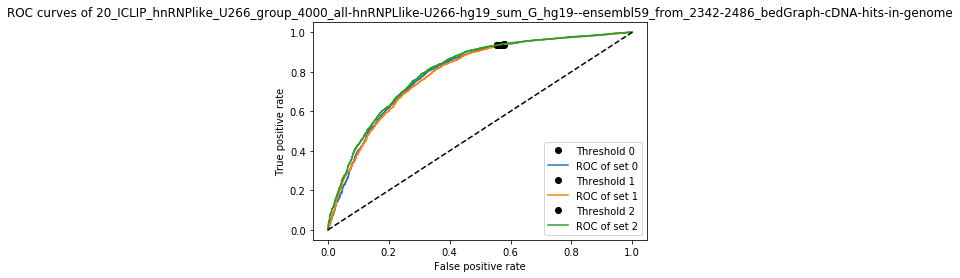

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.7975334687500001 across all three datasets.
21_PARCLIP_MOV10_Sievers_hg19


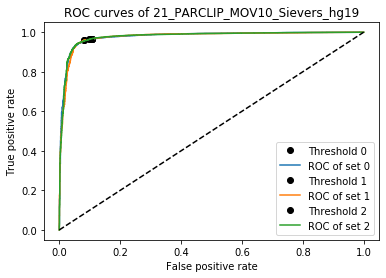

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 21_PARCLIP_MOV10_Sievers_hg19, with the average AUC of 0.9769656875 across all three datasets.
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


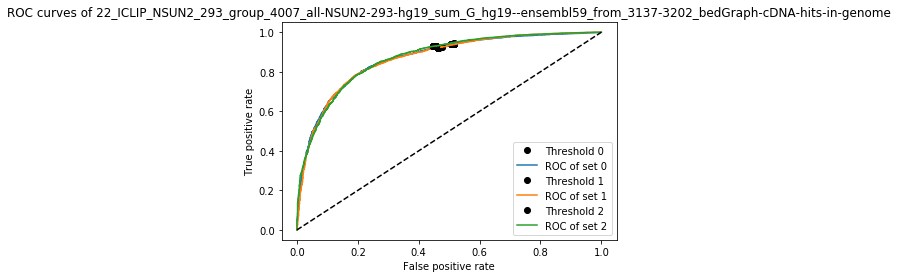

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome, with the average AUC of 0.8685512083333333 across all three datasets.
23_PARCLIP_PUM2_hg19


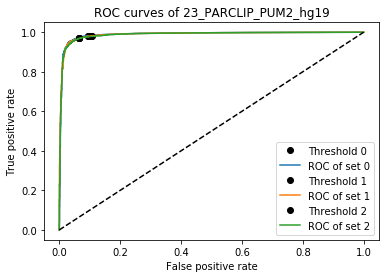

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 23_PARCLIP_PUM2_hg19, with the average AUC of 0.9880345729166667 across all three datasets.
24_PARCLIP_QKI_hg19


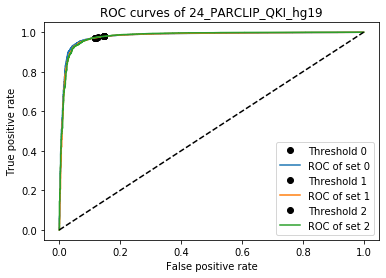

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 24_PARCLIP_QKI_hg19, with the average AUC of 0.9792528645833333 across all three datasets.
25_CLIPSEQ_SFRS1_hg19


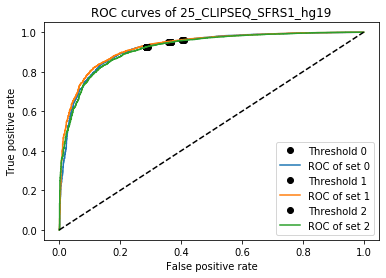

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 25_CLIPSEQ_SFRS1_hg19, with the average AUC of 0.9225929270833332 across all three datasets.
26_PARCLIP_TAF15_hg19


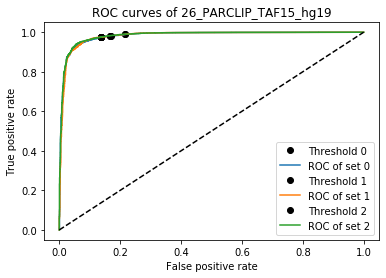

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 26_PARCLIP_TAF15_hg19, with the average AUC of 0.9818128645833334 across all three datasets.
27_ICLIP_TDP43_hg19


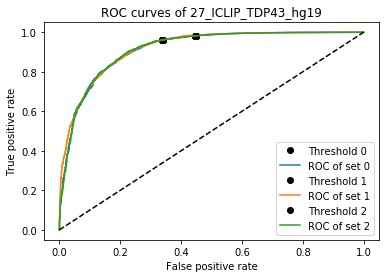

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 27_ICLIP_TDP43_hg19, with the average AUC of 0.9160058958333335 across all three datasets.
28_ICLIP_TIA1_hg19


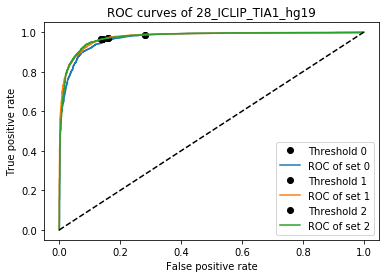

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 28_ICLIP_TIA1_hg19, with the average AUC of 0.9735055729166667 across all three datasets.
29_ICLIP_TIAL1_hg19


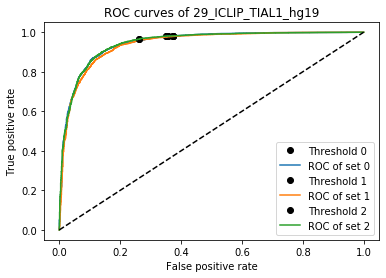

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 29_ICLIP_TIAL1_hg19, with the average AUC of 0.9438058020833333 across all three datasets.
30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


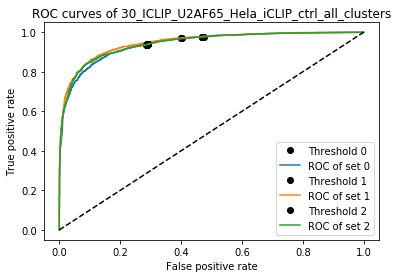

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters, with the average AUC of 0.9438112291666667 across all three datasets.
31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


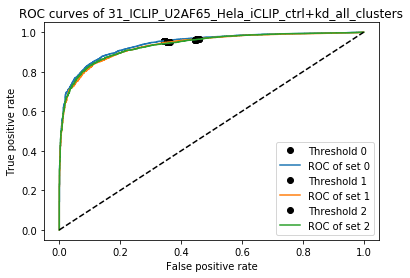

Plots of accuracy, loss function during traing and a ROC curve of model's predictions on 31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters, with the average AUC of 0.9369199270833333 across all three datasets.


In [58]:
# Plot accuracy, loss values and ROC.

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
scores_dict = {}
for protein in protein_list:
    average_score = np.zeros(3)
    print (protein)

    for training_set_number in range (3):
        #Load the model metrics generated with model fit.
        
#         with open ("results/set_%s/%s/metrics" % (training_set_number, protein), "rb") as pickle_file:
#             metrics = pickle.load(pickle_file, encoding="latin1")
        
#             # Plot history for accuracy.                
#             plt.figure (1)
#             plt.plot(metrics.history['acc'])
#             plt.plot(metrics.history['val_acc'])
#             plt.title('model accuracy')
#             plt.ylabel('accuracy')
#             plt.xlabel('epoch')
#             plt.legend(['train', 'validation'], loc='upper left')
            

#             # Plot loss function history.
#             plt.figure (2)
#             plt.plot(metrics.history['loss'])
#             plt.plot(metrics.history['val_loss'])
#             plt.title('model loss')
#             plt.ylabel('loss')
#             plt.xlabel('epoch')
#             plt.legend(['train', 'validation'], loc='upper left')
          

        #Load model predictions.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "rb") as predictions_file:
            loaded_predictions = np.load (predictions_file)

            # Evaluate model performance.
            y_scores = loaded_predictions [:,0:1]
            y_test = get_class(protein,"test",training_set_number)
            y_test = y_test [:,0:1]

            score = roc_auc_score(y_test, y_scores)

            fpr, tpr, thresholds = roc_curve(y_test, y_scores)
            thresholds = np.round(thresholds, 2)

            t_index =  np.where(thresholds == 0.50)[0]
       
            #ROC plot
            plt.figure(3)
            plt.plot(fpr[t_index], tpr[t_index], 'ok', label="Threshold {}".format(training_set_number))
            plt.plot(fpr, tpr, label="ROC of set {}".format(training_set_number))
       
                 
        average_score[training_set_number] = score
    
    scores_dict[protein] = np.mean(average_score)
    plt.figure(3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curves of %s' %protein)
    plt.legend(loc='best')
    plt.savefig('results/ROC/{}.png'.format(protein))
    plt.show()
    print ("Plots of accuracy, loss function during traing and a ROC curve of model's predictions on %s, with the average AUC of %s across all three datasets." % (protein, np.mean(average_score)))
   
    plt.close('all')

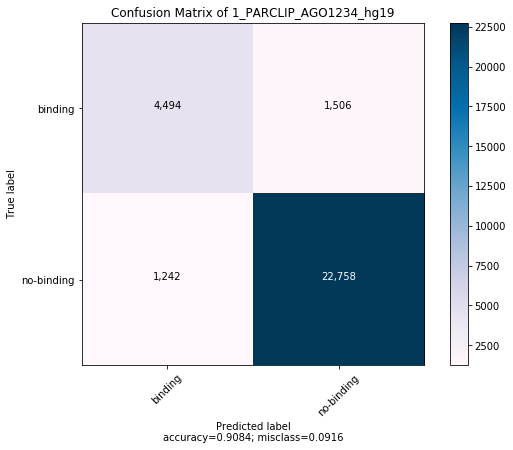

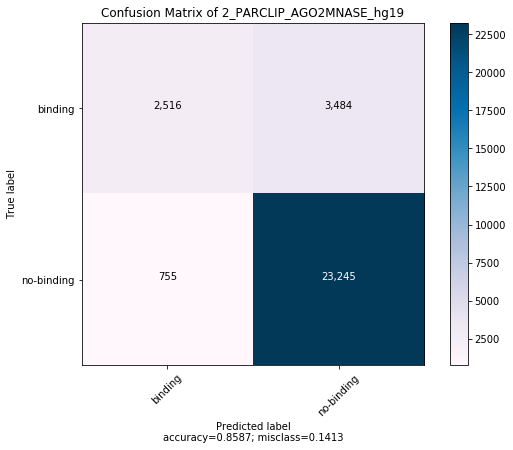

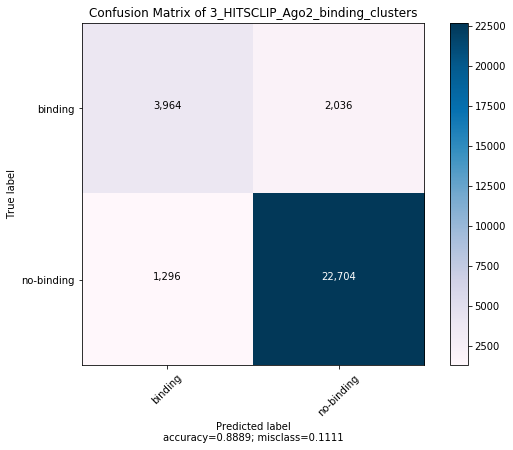

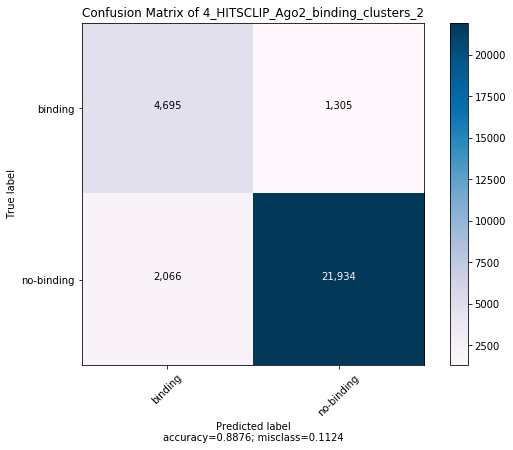

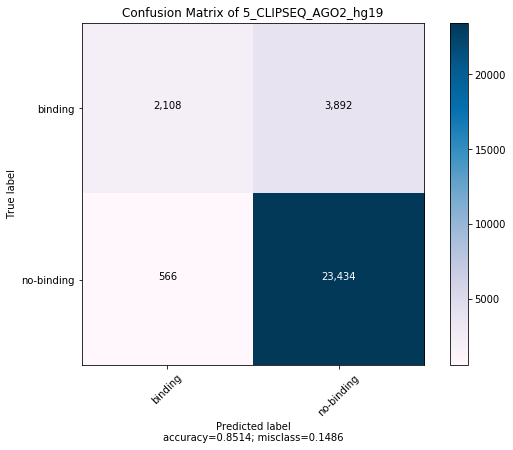

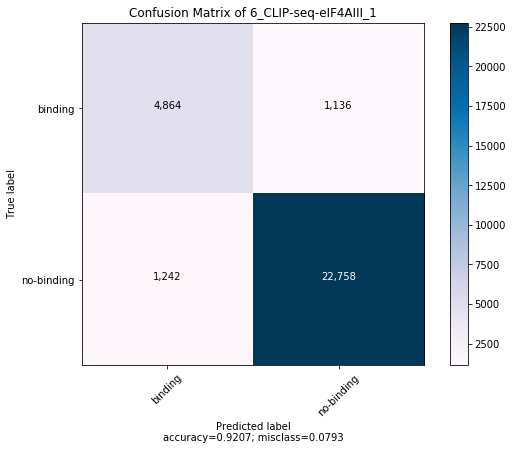

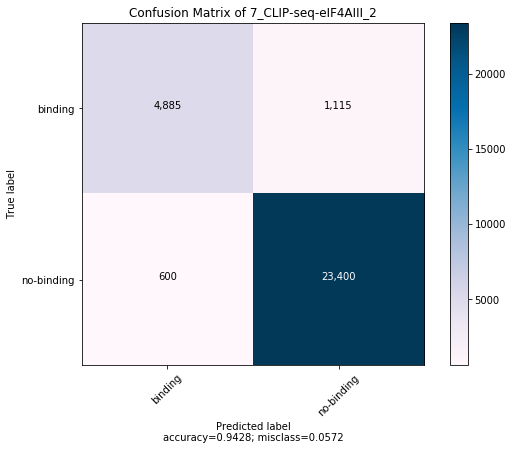

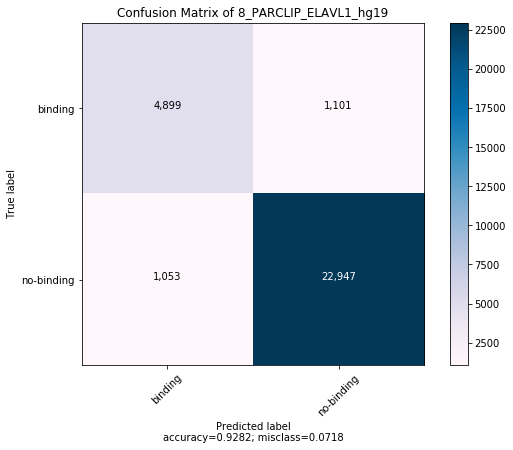

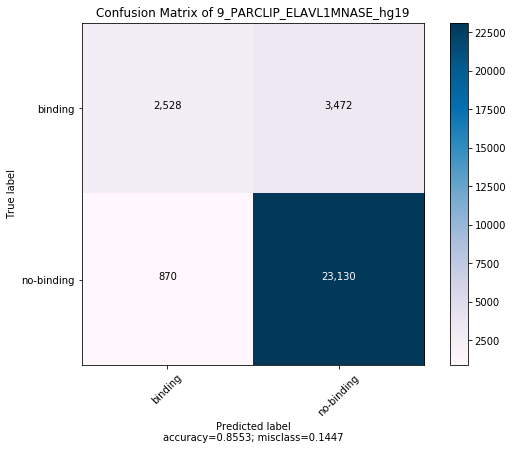

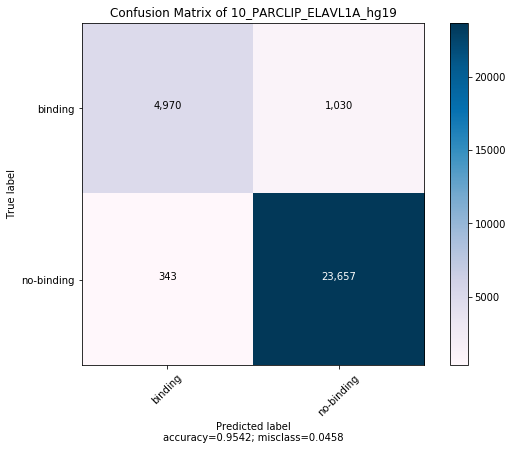

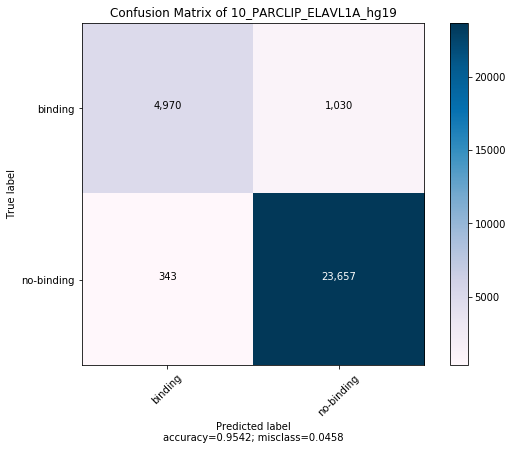

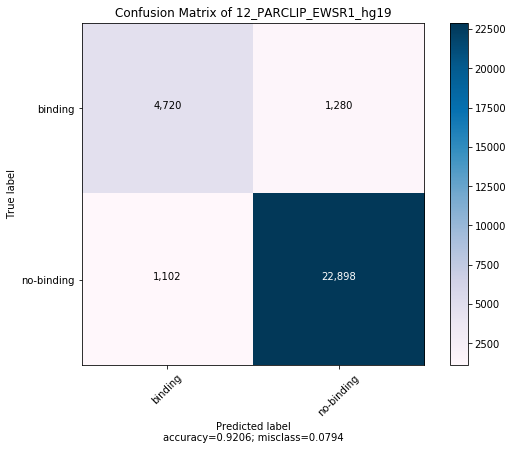

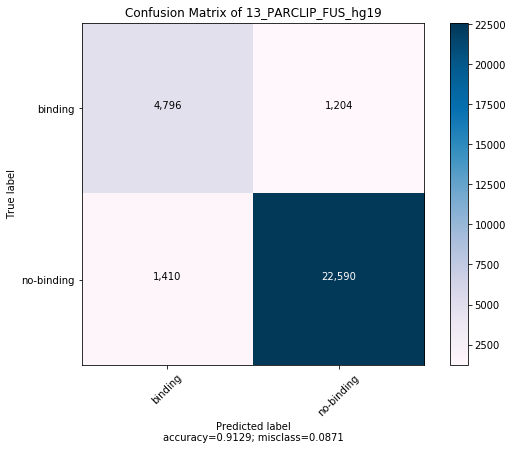

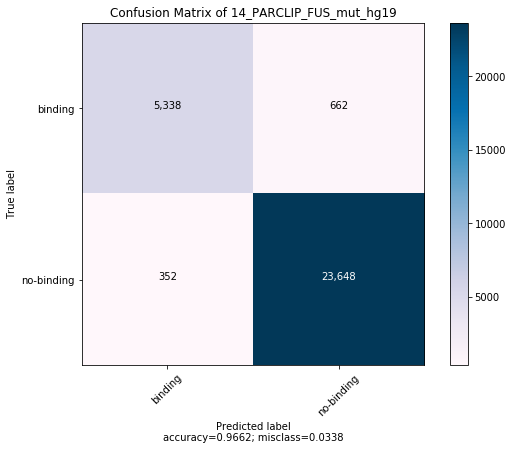

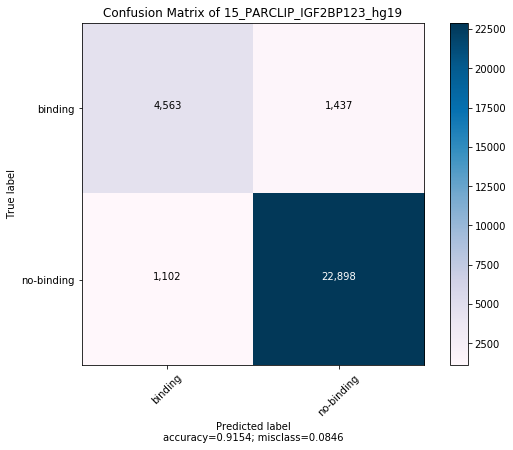

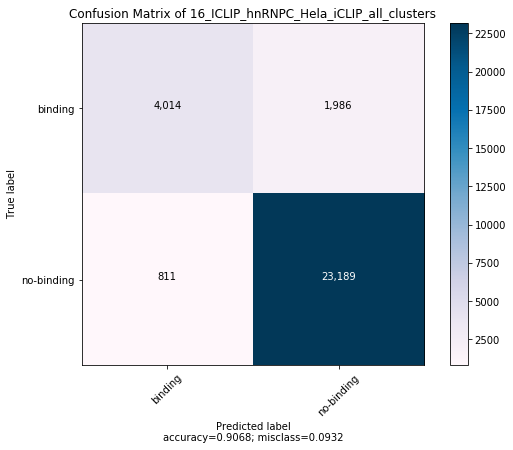

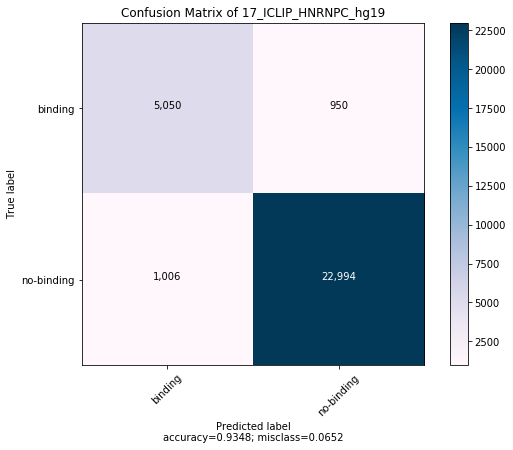

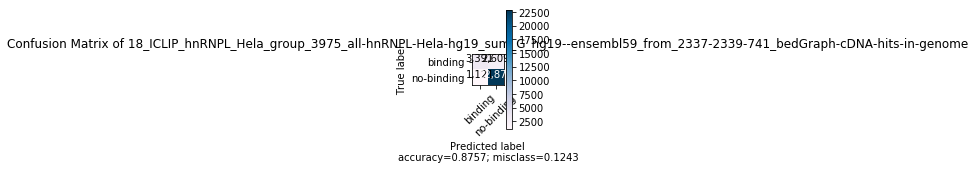

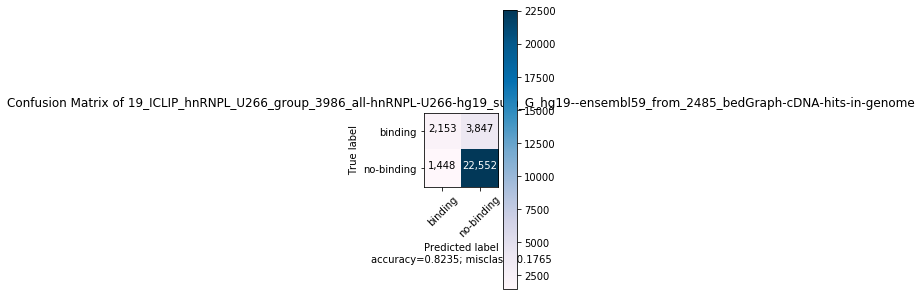

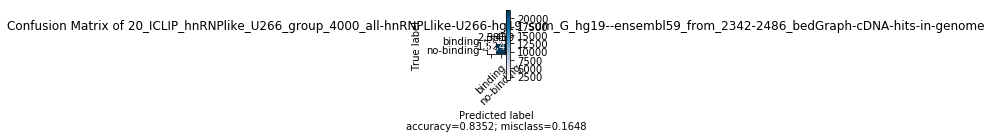

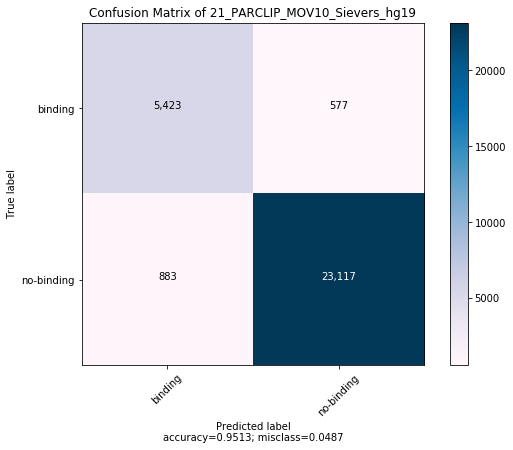

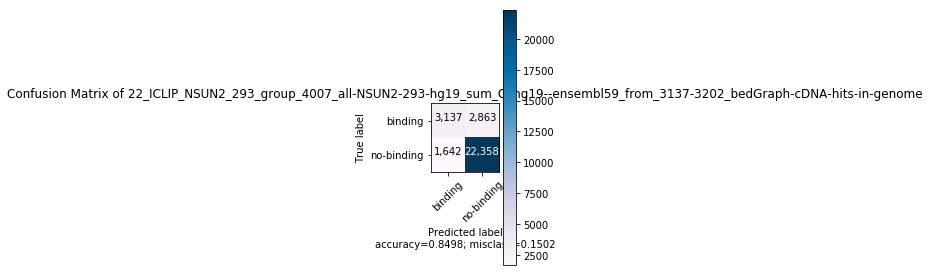

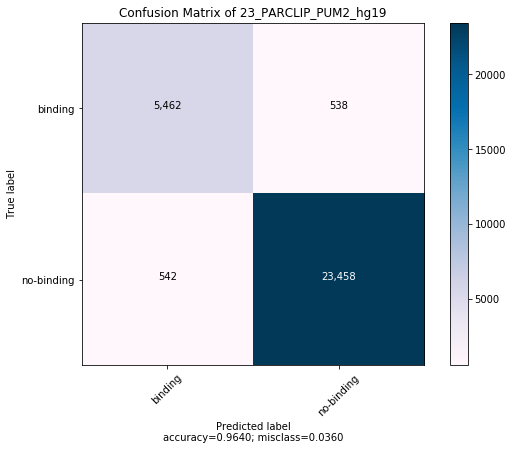

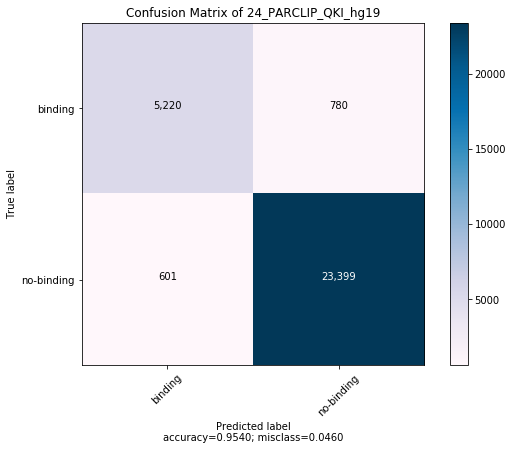

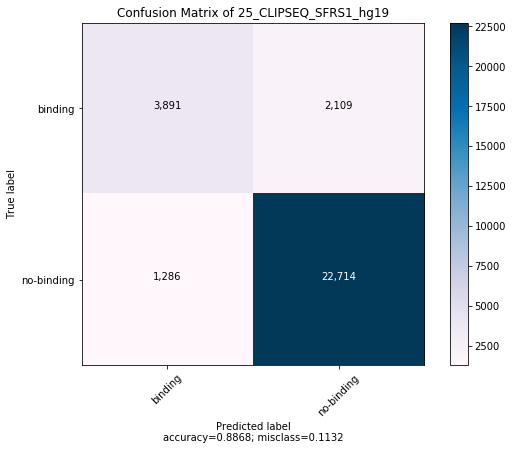

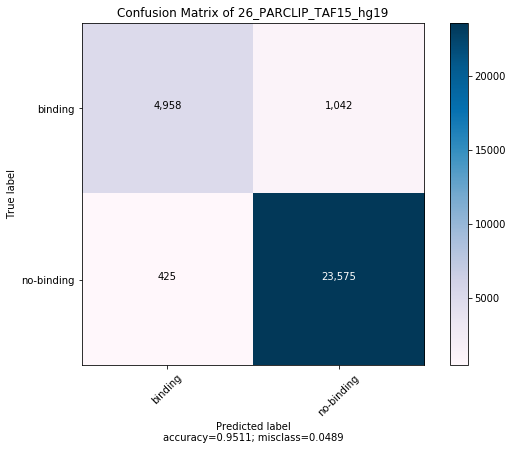

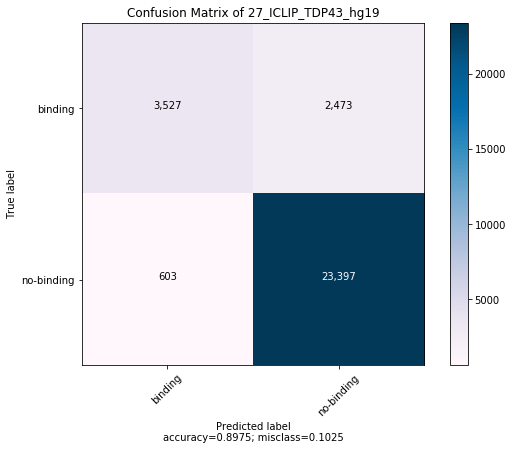

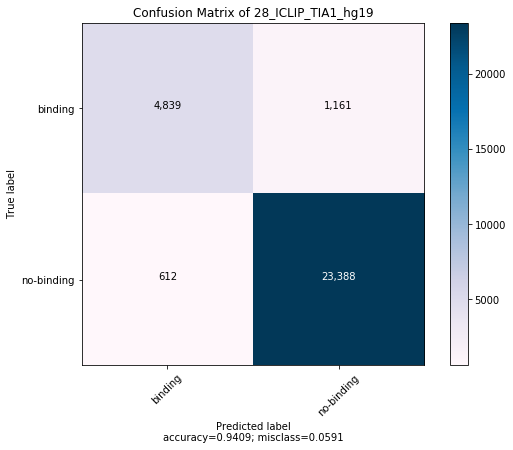

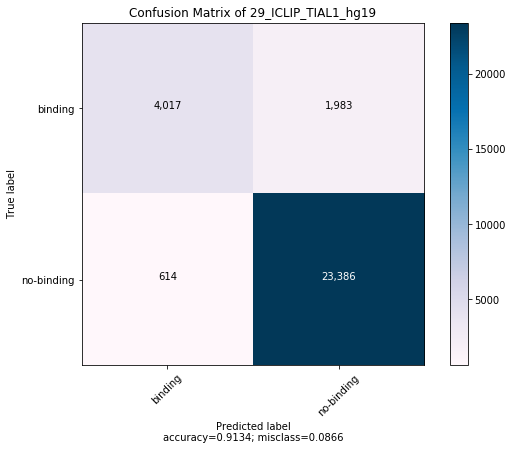

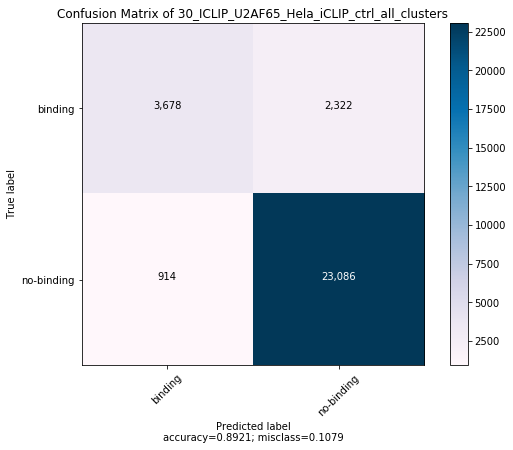

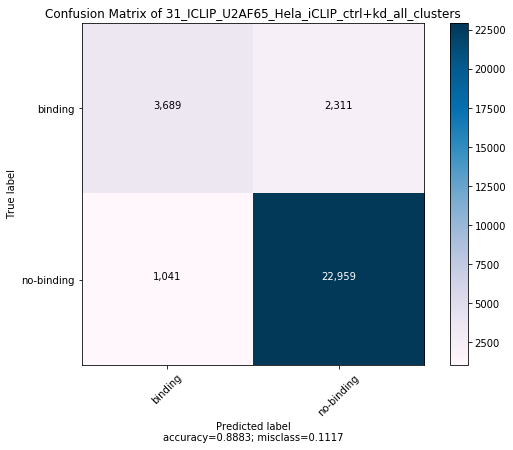

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=None):
    """

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('PuBu')

    plt.figure(figsize=(8, 6))
    plt.imshow((cm), interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
  
    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []

    for training_set_number in range (3):
        
        #Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)

            #Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            binary_prediction = np.argmax(prediction,axis=1)

            #y_test = np.argmax(y_test, axis=1)
            y_test = get_class(protein,"test",training_set_number)[:,1]
            y_test
            

            complete_predictions.append(binary_prediction[:])
            complete_y_test.append(y_test[:])
            

    complete_predictions = np.ravel(complete_predictions)
    complete_y_test = np.ravel(complete_y_test) 
       
  
    cm = confusion_matrix(complete_y_test, complete_predictions)
    # Outputs an array with [tn, fp], [fn, tp]
    
    
    cm = np.flip(cm, 0)
    cm = np.flip(cm, 1)

    
    plot_confusion_matrix(cm, target_names = ['binding', 'no-binding'], 
                      title = "Confusion Matrix of %s" % (protein),
                      cmap = 'PuBu')
       
            


1_PARCLIP_AGO1234_hg19


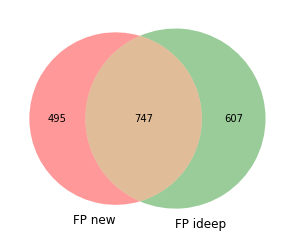

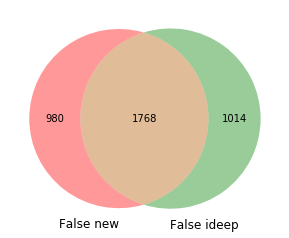

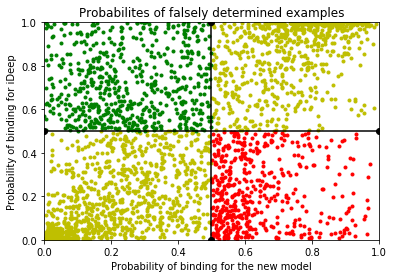

2_PARCLIP_AGO2MNASE_hg19


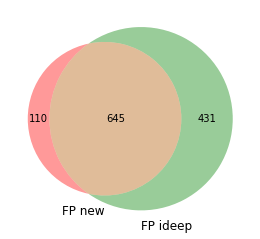

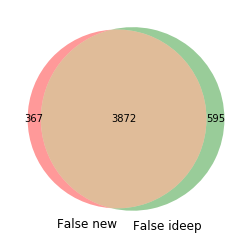

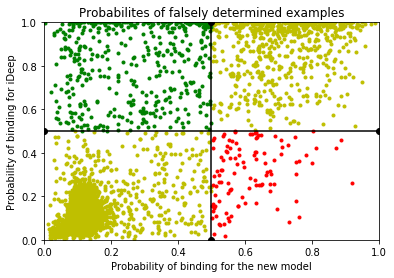

3_HITSCLIP_Ago2_binding_clusters


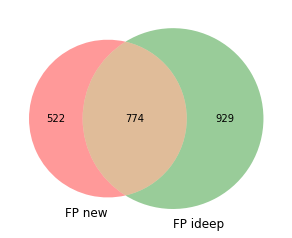

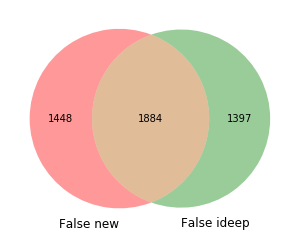

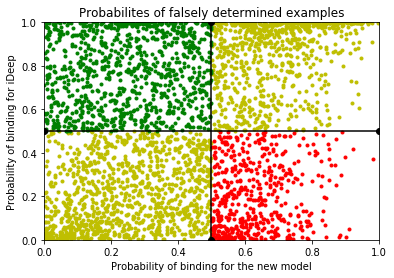

4_HITSCLIP_Ago2_binding_clusters_2


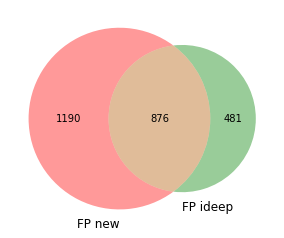

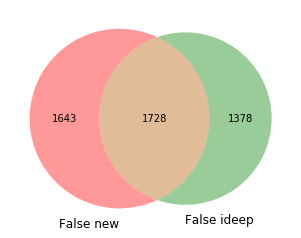

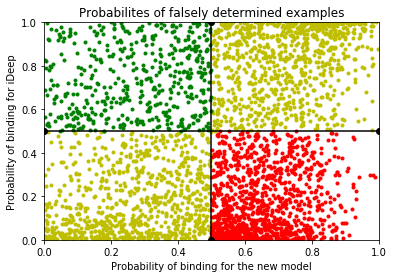

5_CLIPSEQ_AGO2_hg19


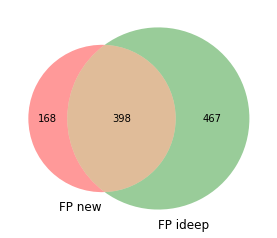

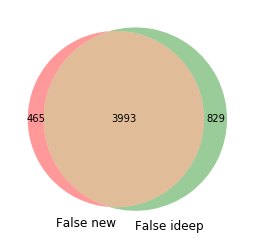

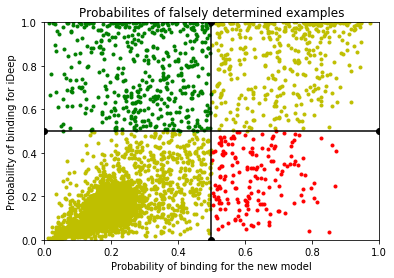

6_CLIP-seq-eIF4AIII_1


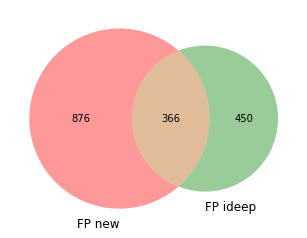

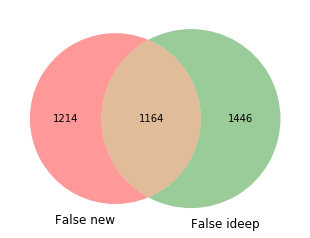

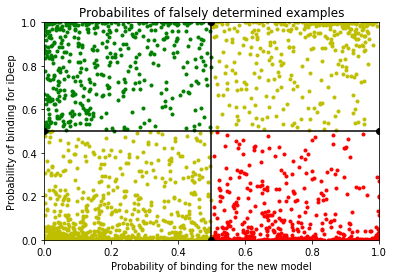

7_CLIP-seq-eIF4AIII_2


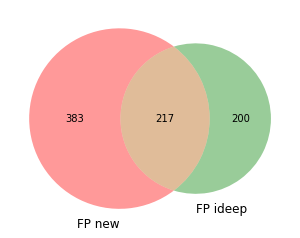

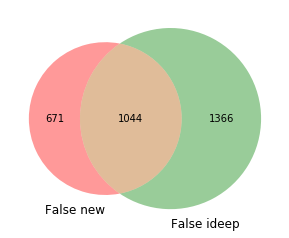

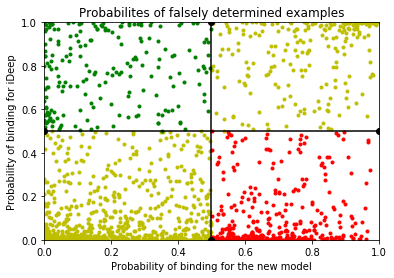

8_PARCLIP_ELAVL1_hg19


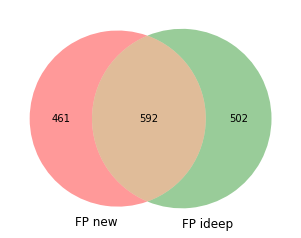

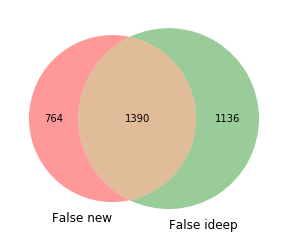

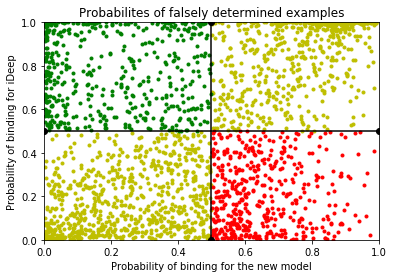

9_PARCLIP_ELAVL1MNASE_hg19


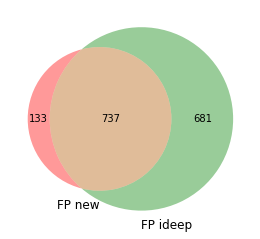

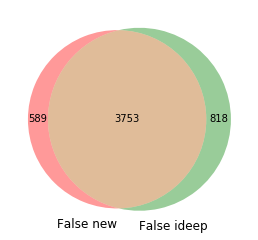

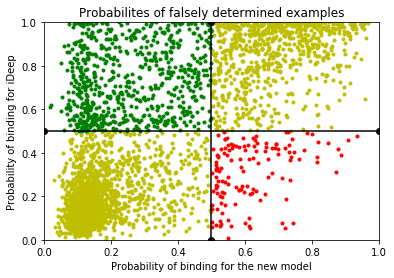

10_PARCLIP_ELAVL1A_hg19


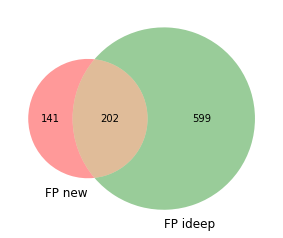

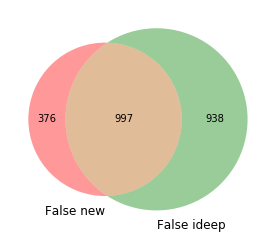

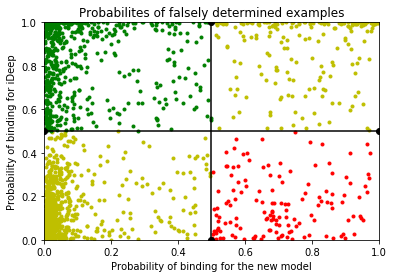

10_PARCLIP_ELAVL1A_hg19


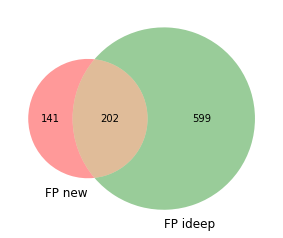

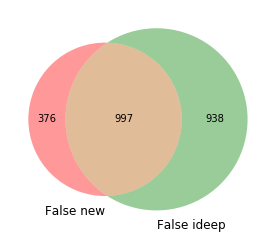

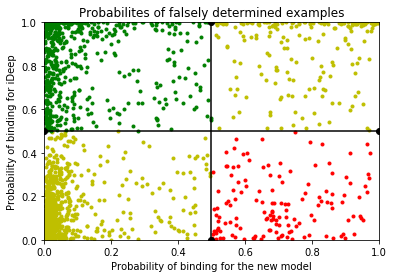

12_PARCLIP_EWSR1_hg19


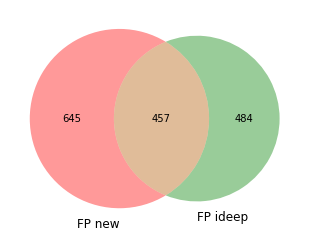

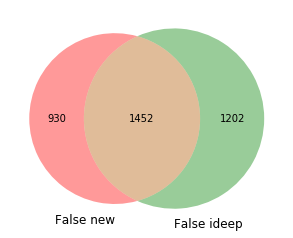

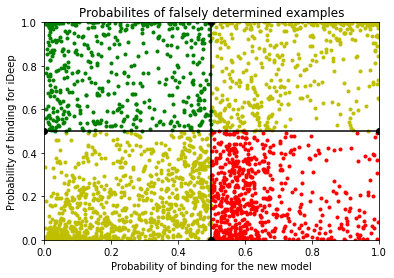

13_PARCLIP_FUS_hg19


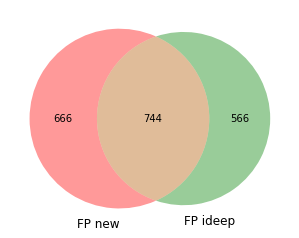

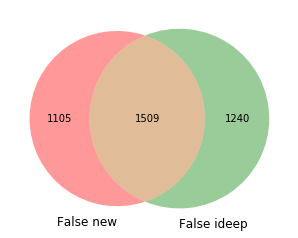

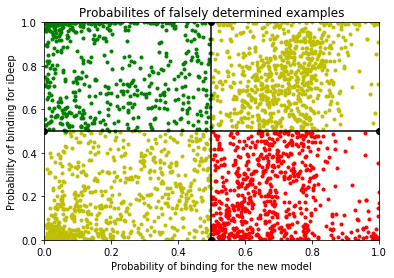

14_PARCLIP_FUS_mut_hg19


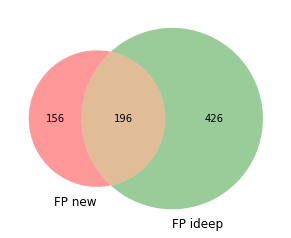

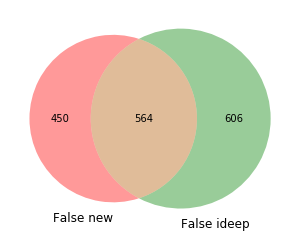

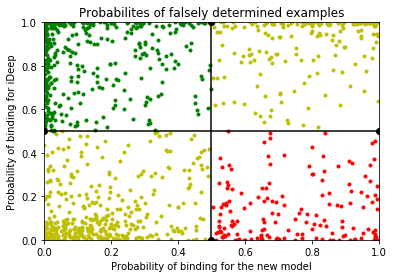

15_PARCLIP_IGF2BP123_hg19


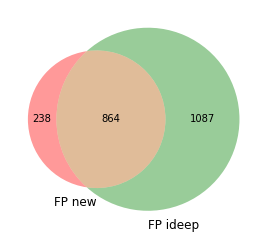

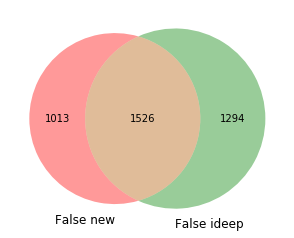

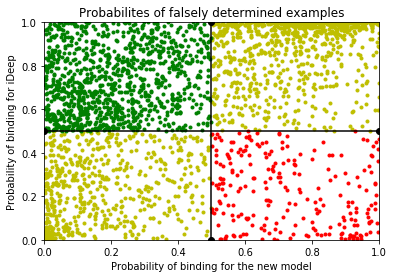

16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters


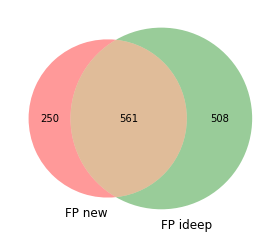

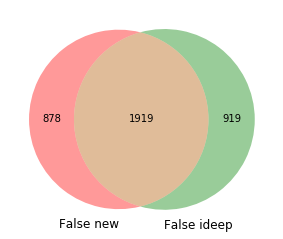

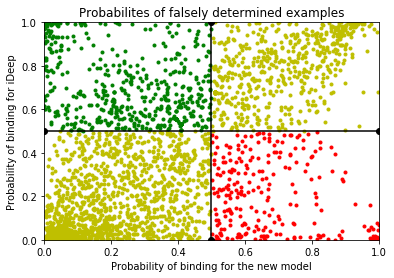

17_ICLIP_HNRNPC_hg19


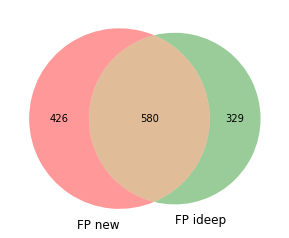

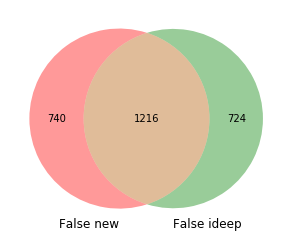

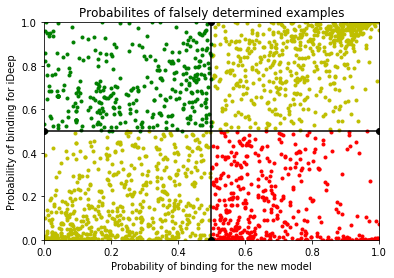

18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome


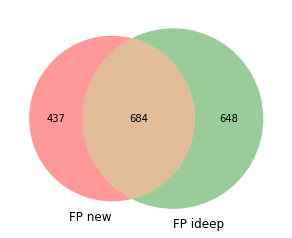

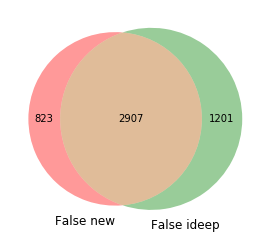

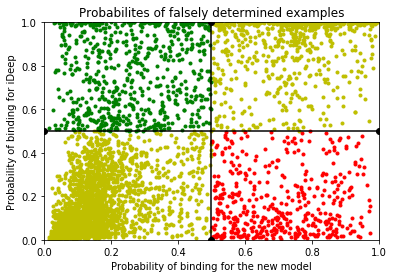

19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome


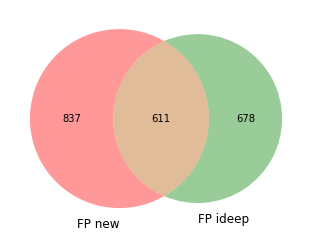

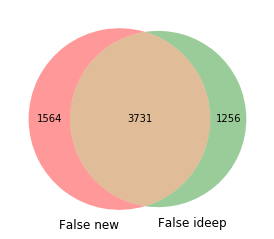

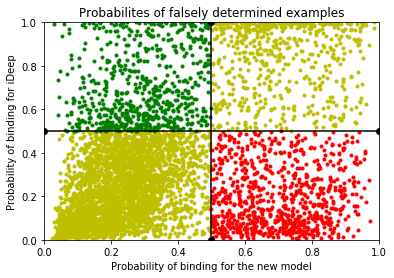

20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome


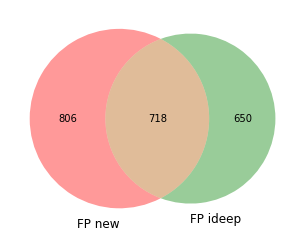

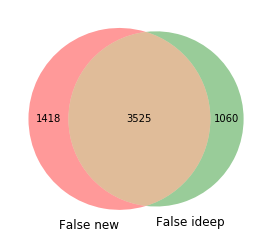

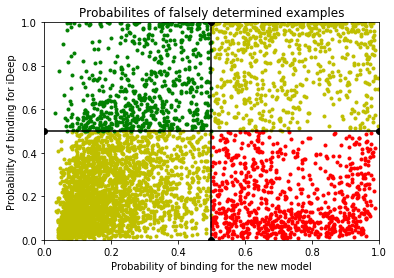

21_PARCLIP_MOV10_Sievers_hg19


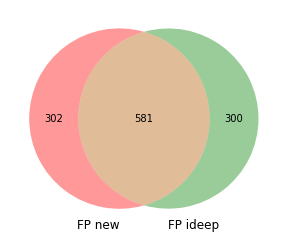

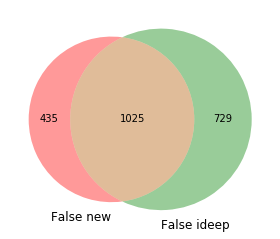

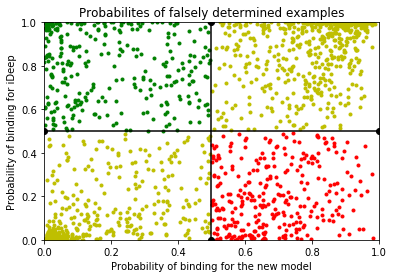

22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome


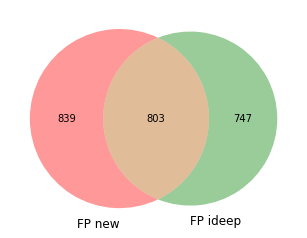

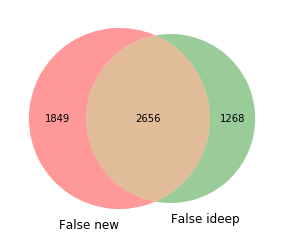

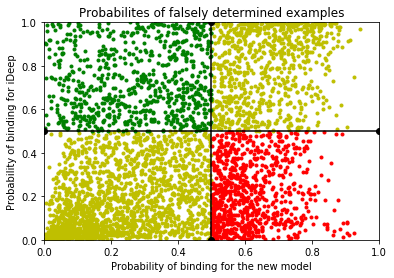

23_PARCLIP_PUM2_hg19


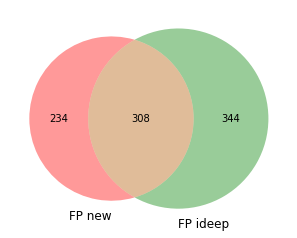

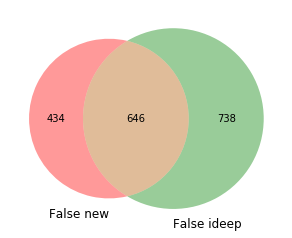

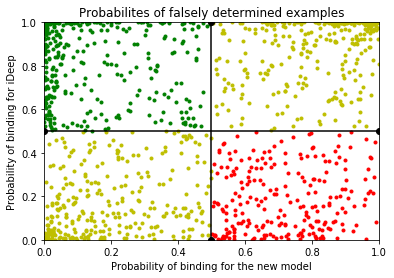

24_PARCLIP_QKI_hg19


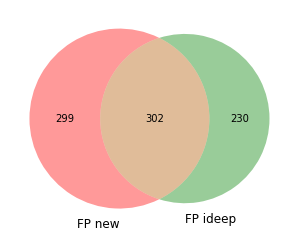

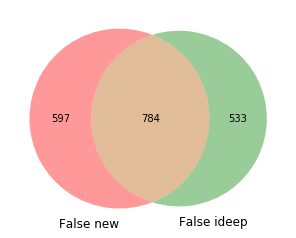

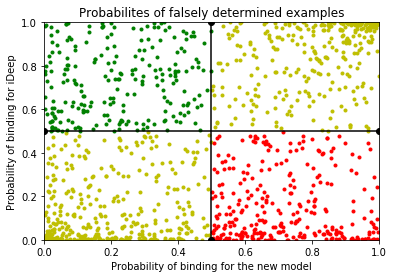

25_CLIPSEQ_SFRS1_hg19


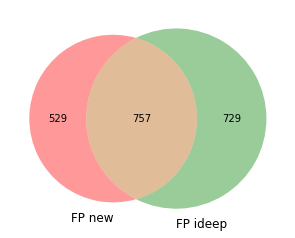

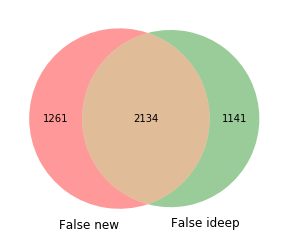

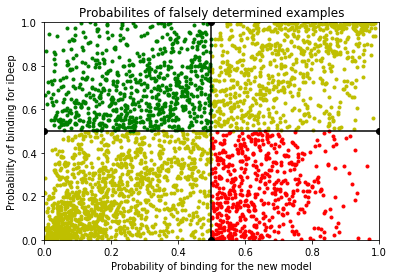

26_PARCLIP_TAF15_hg19


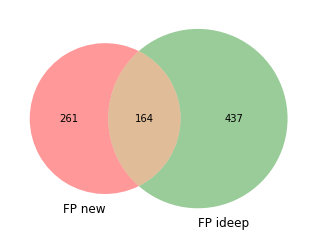

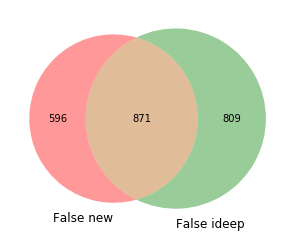

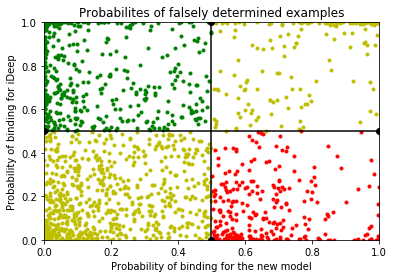

27_ICLIP_TDP43_hg19


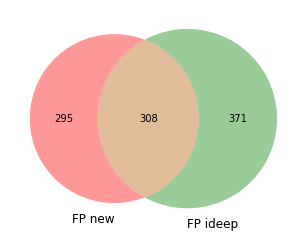

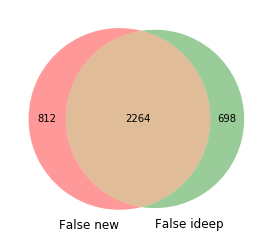

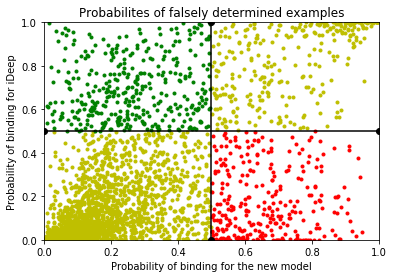

28_ICLIP_TIA1_hg19


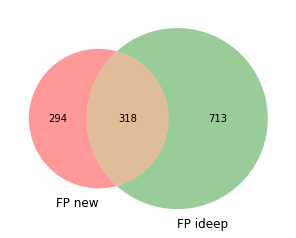

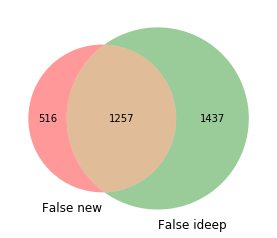

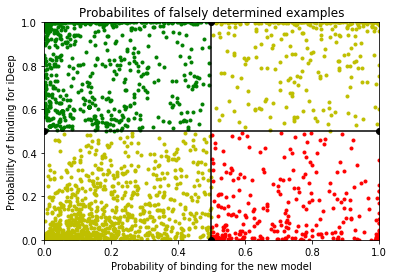

29_ICLIP_TIAL1_hg19


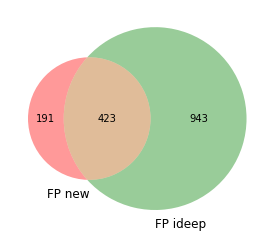

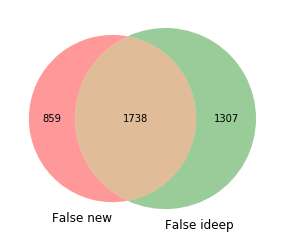

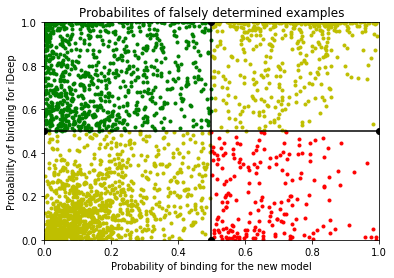

30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters


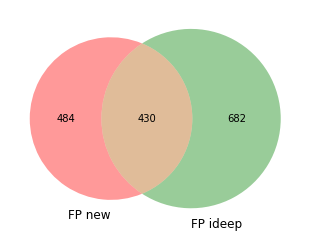

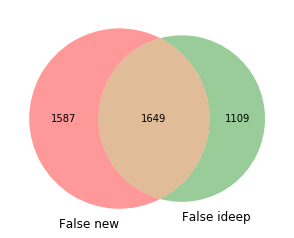

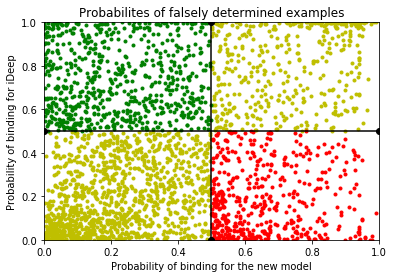

31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters


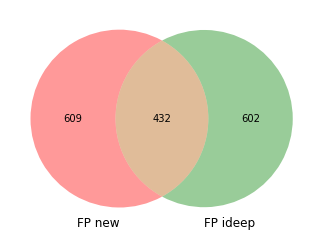

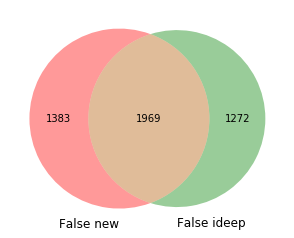

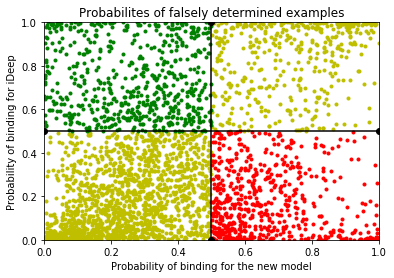

In [6]:
from matplotlib_venn import venn2

# find indices of different predictions.
def find_fp_index(true_label, predicted_label):
    fp_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 1 and true_label[i] == 0:
            fp_indices.append(i)
    return np.array(fp_indices)

def find_fn_index(true_label, predicted_label):
    fn_indices = []
    for i in range (len(predicted_label)):
        if predicted_label[i] == 0 and true_label[i] == 1:
            fn_indices.append(i)
    return np.array(fn_indices)

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]

    
for protein in protein_list:
    complete_predictions = []
    complete_y_test = []
    complete_ideep = []
    binary_prediction = np.zeros(30000)
    binary_ideep = np.zeros(30000)
    
    
    print (protein)
    
    for training_set_number in range (3):

        # Load the model predictions of test datast.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "r") as predictions_file:
            prediction = np.load(predictions_file)          
            
            y_test = get_class(protein,"test",training_set_number)[:,1]
                        
            # Generated binary values are appended to a new array.
            complete_predictions.append(prediction[:,1])
            complete_y_test.append(y_test[:])
            
            predictions_ravel = np.ravel(complete_predictions)
            
            # Read the index of the highest number from the arrays; 0 means there was no binding, 1 means there was protein bound
            for i in range (len(predictions_ravel)):
                            if predictions_ravel[i] > 0.50:
                                binary_prediction[i] = 1
                            else:
                                binary_prediction[i] = 0
            
        with open ("ideep_results/predictions%s/%s" % (training_set_number, protein), "r") as ideep_file:
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
                        
            complete_ideep.append(ideep_prediction[:])
            
            ideep_ravel = np.ravel(complete_ideep)
            
            for i in range (len(ideep_ravel)):
                if ideep_ravel[i] > 0.50:
                    binary_ideep[i] = 1
                else:
                    binary_ideep[i] = 0
            
            
            
    
    binary_prediction = np.ravel(binary_prediction)
    complete_y_test = np.ravel(complete_y_test)
    binary_ideep = np.ravel(binary_ideep)
    #print (len(binary_ideep),len(binary_prediction))
    
    # Indices of false positives and false negatives from all of the datasets are stored as fp and fn.
    fp = find_fp_index(complete_y_test, binary_prediction)     
    fn = find_fn_index (complete_y_test, binary_prediction)

    #print (len(fp),len(fn))
    
    fp_ideep = find_fp_index(complete_y_test, binary_ideep)     
    fn_ideep = find_fn_index (complete_y_test, binary_ideep)
    #print (len(fp_ideep),len(fn_ideep))

    common_indices = np.intersect1d(fp, fp_ideep)
    #print (len(fp_ideep)-len(common_indices))
    venn2(subsets = ((len(fp)-len(common_indices)), (len(fp_ideep)-len(common_indices)), len(common_indices)), set_labels = ('FP new', 'FP ideep'))
    plt.show()

    #Merge both fb and fn for venn diagram of false predictions.
    false_new = np.append (fp,fn)
    false_ideep = np.append(fp_ideep,fn_ideep)
    common_false_indices = np.intersect1d(false_new, false_ideep)

    venn2(subsets = (len(false_new)-len(common_false_indices), len(false_ideep)-len(common_false_indices), len(common_false_indices)), set_labels = ('False new', 'False ideep'))
    plt.show()
    
    '''
    Graaphing values of falsely determined examples.
    '''
    # Get probability values of predictions which were false in both.
    new_common_f = []
    ideep_common_f = []
    for index in common_false_indices:

        new_common_f.append(predictions_ravel[index])
        ideep_common_f.append(ideep_ravel[index])

    #print (len(new_common_f),len(ideep_common_f))

    # Get probability values of predictions which were false positives in ideep
    new_correct_values = []
    fp_ideep_values = []
    for index in (np.setdiff1d(fp_ideep, fp)):

        new_correct_values.append(predictions_ravel[index])
        fp_ideep_values.append(ideep_ravel[index])

    #print (len(np.setdiff1d(fp_ideep, fp)))


    # Get probability values of predictions which were false positives in the new model
    ideep_correct_values = []
    fp_new_values = []
    for index in (np.setdiff1d(fp, fp_ideep)):

        fp_new_values.append(predictions_ravel[index])
        ideep_correct_values.append(ideep_ravel[index])

    #print (ideep_prediction_probabilities)
    #print (len(np.setdiff1d(fp, fp_ideep)))


    #print (prediction_probabilities)
    plt.title ('Probabilites of falsely determined examples')
    plt.xlabel('Probability of binding for the new model')
    plt.ylabel('Probability of binding for iDeep')
    plt.plot(new_common_f, ideep_common_f, 'y.')
    plt.plot(new_correct_values, fp_ideep_values, 'g.')
    plt.plot(fp_new_values, ideep_correct_values, 'r.')
    plt.plot([0.5,0.5],[0,1], 'ko-')
    plt.plot([0,1],[0.5,0.5], 'ko-')
    plt.axis([0, 1, 0, 1])
    plt.show()


In [12]:
from sklearn.calibration import calibration_curve
import numpy as np
import matplotlib.style as style

    
protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
for protein in protein_list:
    average_score = np.zeros(3)
    print (protein)
    complete_ideep_prediction = []
    y_scores = []
    total_y_test = []
    
    for training_set_number in range (3):
        #Load model predictions.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "rb") as predictions_file,\
            open ("ideep_results/predictions%s/%s" % (training_set_number, protein), "r") as ideep_file:
            loaded_predictions = np.load(predictions_file, encoding="bytes")
            ideep_prediction = np.loadtxt(ideep_file, delimiter="\n", unpack=False)
            ideep_prediction = np.array(ideep_prediction)
            complete_ideep_prediction = np.append(complete_ideep_prediction, ideep_prediction)
            # Evaluate model performance.
            y_scores = np.append(y_scores, loaded_predictions[:, 1])
            y_test = get_class(protein,"test",training_set_number)
            total_y_test = np.append(total_y_test, y_test[:, 1])
    y_scores.flatten()
    total_y_test.flatten()
    complete_ideep_prediction.flatten()
    fraction_of_positives, mean_predicted_value = calibration_curve(total_y_test, y_scores, n_bins=50)
    ideep_frp, ideep_mpv = calibration_curve(total_y_test, complete_ideep_prediction, n_bins=50)

    style.use('seaborn-poster')
    fig = plt.figure(figsize=(10, 12))
    ax1 = plt.subplot2grid((5, 1), (0, 0), rowspan=3)
    ax2 = plt.subplot2grid((5, 1), (3, 0), sharex=ax1)
    ax3 = plt.subplot2grid((5, 1), (4, 0), sharex=ax1)
    
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax1.plot(mean_predicted_value, fraction_of_positives, label="mcBind")
    ax1.plot(ideep_mpv, ideep_frp, label="iDeep")
    ax1.set_ylabel("Fraction of positives")
    ax1.legend(loc="upper left")


    ax2.hist(y_scores[total_y_test==0], range=(0, 1), bins=50, histtype="stepfilled", label="Negative samples", alpha=0.4, color='tab:blue', edgecolor = "#04080d", linewidth=1.5)
    ax2.hist(y_scores[total_y_test==1], range=(0, 1), bins=50, histtype="stepfilled", label="Positive samples", alpha=0.75, color='tab:blue')

    ax3.hist(complete_ideep_prediction[total_y_test==0], range=(0, 1), bins=50, histtype="stepfilled", lw=2, label="Negative samples", alpha=0.4, color='tab:orange', edgecolor = "black", linewidth=1.5)
    ax3.hist(complete_ideep_prediction[total_y_test==1], range=(0, 1), bins=50, histtype="stepfilled", lw=2, label="Positive samples",alpha=0.75, color='tab:orange')


    ax2.legend(loc="upper center")
    ax3.legend(loc="upper center")
    ax2.set_ylabel("Log (Count)")
    ax2.set_yscale("log")
    ax3.set_ylabel("Log (Count)")
    ax3.set_xlabel("Mean predicted value")
    ax3.set_yscale("log")

    top_max = max(ax2.get_ylim()[1], ax3.get_ylim()[1])

    ax2.set_ylim(top=top_max)
    ax3.set_ylim(top=top_max)


    fig.tight_layout()
    fig.subplots_adjust(hspace=0.03)
    
    for ax in [ax1, ax2, ax3]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
   
    plt.savefig("results/calibration_curves2/{}_calibration_curve.png".format(protein))
    # plt.show()
    plt.close()

1_PARCLIP_AGO1234_hg19
2_PARCLIP_AGO2MNASE_hg19
3_HITSCLIP_Ago2_binding_clusters
4_HITSCLIP_Ago2_binding_clusters_2
5_CLIPSEQ_AGO2_hg19
6_CLIP-seq-eIF4AIII_1
7_CLIP-seq-eIF4AIII_2
8_PARCLIP_ELAVL1_hg19
9_PARCLIP_ELAVL1MNASE_hg19
10_PARCLIP_ELAVL1A_hg19
10_PARCLIP_ELAVL1A_hg19
12_PARCLIP_EWSR1_hg19
13_PARCLIP_FUS_hg19
14_PARCLIP_FUS_mut_hg19
15_PARCLIP_IGF2BP123_hg19
16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters
17_ICLIP_HNRNPC_hg19
18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome
19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome
20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome
21_PARCLIP_MOV10_Sievers_hg19
22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome
23_PARCLIP_PUM2_hg19
24_PARCLIP_QKI_hg19
25_CLIPSEQ_SFRS1_hg19

In [105]:
import matplotlib.style as style
import matplotlib.font_manager as fnt_manager
style.available
# [f.name for f in fnt_manager.fontManager.afmlist]

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

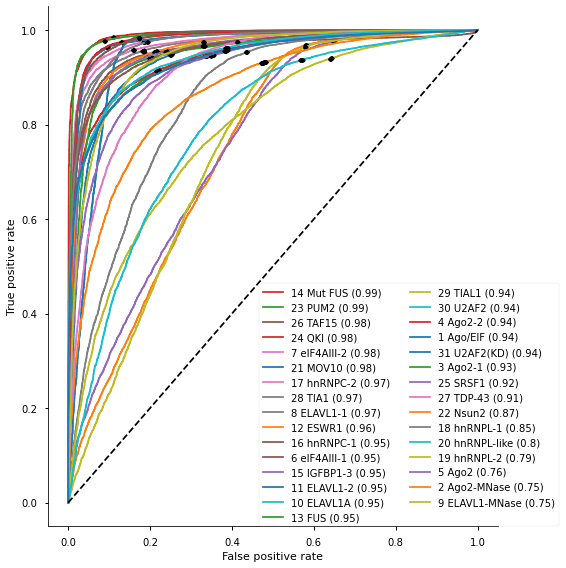

In [6]:
import matplotlib.style as style

protein_list = ["1_PARCLIP_AGO1234_hg19", "2_PARCLIP_AGO2MNASE_hg19","3_HITSCLIP_Ago2_binding_clusters","4_HITSCLIP_Ago2_binding_clusters_2","5_CLIPSEQ_AGO2_hg19", "6_CLIP-seq-eIF4AIII_1","7_CLIP-seq-eIF4AIII_2","8_PARCLIP_ELAVL1_hg19","9_PARCLIP_ELAVL1MNASE_hg19", "10_PARCLIP_ELAVL1A_hg19", "10_PARCLIP_ELAVL1A_hg19", "12_PARCLIP_EWSR1_hg19", "13_PARCLIP_FUS_hg19", "14_PARCLIP_FUS_mut_hg19", "15_PARCLIP_IGF2BP123_hg19", "16_ICLIP_hnRNPC_Hela_iCLIP_all_clusters", "17_ICLIP_HNRNPC_hg19", "18_ICLIP_hnRNPL_Hela_group_3975_all-hnRNPL-Hela-hg19_sum_G_hg19--ensembl59_from_2337-2339-741_bedGraph-cDNA-hits-in-genome", "19_ICLIP_hnRNPL_U266_group_3986_all-hnRNPL-U266-hg19_sum_G_hg19--ensembl59_from_2485_bedGraph-cDNA-hits-in-genome", "20_ICLIP_hnRNPlike_U266_group_4000_all-hnRNPLlike-U266-hg19_sum_G_hg19--ensembl59_from_2342-2486_bedGraph-cDNA-hits-in-genome", "21_PARCLIP_MOV10_Sievers_hg19", "22_ICLIP_NSUN2_293_group_4007_all-NSUN2-293-hg19_sum_G_hg19--ensembl59_from_3137-3202_bedGraph-cDNA-hits-in-genome", "23_PARCLIP_PUM2_hg19", "24_PARCLIP_QKI_hg19", "25_CLIPSEQ_SFRS1_hg19","26_PARCLIP_TAF15_hg19", "27_ICLIP_TDP43_hg19", "28_ICLIP_TIA1_hg19", "29_ICLIP_TIAL1_hg19", "30_ICLIP_U2AF65_Hela_iCLIP_ctrl_all_clusters", "31_ICLIP_U2AF65_Hela_iCLIP_ctrl+kd_all_clusters"]
protein_names = ['1 Ago/EIF', '2 Ago2-MNase', '3 Ago2-1', '4 Ago2-2', '5 Ago2', '6 eIF4AIII-1', '7 eIF4AIII-2', '8 ELAVL1-1', '9 ELAVL1-MNase', '10 ELAVL1A', '11 ELAVL1-2', '12 ESWR1', '13 FUS', '14 Mut FUS', '15 IGFBP1-3', '16 hnRNPC-1', '17 hnRNPC-2', '18 hnRNPL-1', '19 hnRNPL-2', '20 hnRNPL-like', '21 MOV10', '22 Nsun2', '23 PUM2', '24 QKI', '25 SRSF1' , '26 TAF15', '27 TDP-43', '28 TIA1', '29 TIAL1', '30 U2AF2', '31 U2AF2(KD)']

style.use('seaborn-notebook')

scores_dict = {}
auc={}
fig, ax = plt.subplots(figsize=(8, 8))
for protein, name in zip(protein_list, protein_names):
    complete_y_test = None
    complete_y_scores = None
    for training_set_number in range (3):        
        #Load model predictions.
        with open ("results/set_%s/%s/predictions" % (training_set_number, protein), "rb") as predictions_file:
            loaded_predictions = np.load(predictions_file)
            
            if complete_y_test is not None:
                complete_y_test = np.append(complete_y_test, get_class(protein,"test",training_set_number)[:,0:1])
            else:
                complete_y_test = get_class(protein,"test",training_set_number)[:,0:1]
            
            if complete_y_scores is not None:
                complete_y_scores = np.append(complete_y_scores, loaded_predictions [:,0:1])
            else:
                complete_y_scores = loaded_predictions [:,0:1]
    fpr, tpr, thresholds = roc_curve(complete_y_test, complete_y_scores)
    auc[name] = roc_auc_score(complete_y_test, complete_y_scores)

    thresholds = np.round(thresholds, 2)
#     print(thresholds)
    t_index =  np.where(thresholds == 0.50)[0]
    ax.plot(fpr, tpr, label=f"{name} ({round(auc[name], 2)})")
    ax.plot(fpr[t_index], tpr[t_index], '.k')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlabel('False positive rate')
ax.set_ylabel('True positive rate')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
auc, labels, handles = zip(*sorted(zip(auc.values(), labels, handles), key=lambda t: t[0]))
ax.legend(handles[::-1], labels[::-1], loc=[0.47, 0], ncol=2)
plt.tight_layout()
plt.savefig('results/combined_ROC.svg')
plt.show()